In [18]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import pickle

import pandas as pd

In [19]:
sensor_df = pd.read_csv("https://raw.githubusercontent.com/AllisonOge/predictive_modeling/main/data/sensor_ml.csv", index_col="id")

In [20]:
sensor_copy_df = sensor_df
sensor_copy_df = sensor_copy_df.drop_duplicates(subset="created_at")
sensor_copy_df = sensor_copy_df.set_index("created_at")

In [21]:
def start_and_idle_time(bit_sequence):
    bit_sequence = np.asarray(bit_sequence, dtype=np.int32)
    start_time = 0
    idle_time = 0
    idle_times = []
    for i, bit in enumerate(bit_sequence):
        if i > 0:
            if bit == 0 and bit_sequence[i-1] == 1:
                # 1,0
                start_time = i
                idle_time += 1
            elif bit == 0 and bit_sequence[i-1] == 0:
                # 0,0
                idle_time += 1
            elif bit == 1 and bit_sequence[i-1] == 0:
                # 0,1
                idle_times.append((start_time, idle_time))
                idle_time = 0
        else:
            if bit == 0:
                start_time = i
                idle_time += 1

        if i == len(bit_sequence)-1 and idle_time > 0:
            idle_times.append((start_time, idle_time))

        if len(idle_times) > 1:
            break

    return np.array(idle_times)


In [22]:
def get_idletimes_df(df):
  idle_times = []
  for i in range(df.shape[0]):
    idle_times.append([j[0][1] if len(j) > 0 and i+j[0][0] <= i else 0 
                       for j in  list(map(start_and_idle_time, df.to_numpy()[i:].transpose()))])
    
  return pd.DataFrame(data=idle_times, index=df.index, columns=df.columns)

In [23]:
idle_times_df = get_idletimes_df(sensor_copy_df)
idle_times_df

,chan_1,chan_2,chan_3,chan_4
created_at,,,,
2022-11-15 16:14:18.829480,0,16,16,16
2022-11-15 16:14:18.914676,0,15,15,15
2022-11-15 16:14:18.983745,0,14,14,14
2022-11-15 16:14:19.059611,0,13,13,13
2022-11-15 16:14:19.134008,0,12,12,12
...,...,...,...,...
2022-11-15 16:44:18.563776,0,0,0,0
2022-11-15 16:44:18.693114,0,0,0,0
2022-11-15 16:44:18.755782,0,0,0,0


In [24]:
X = idle_times_df.to_numpy()
np.random.shuffle(X)
X.shape

(23570, 4)

In [25]:
X_train, X_test = X[:len(X)*3//4], X[len(X)*3//4:]
X_train.shape, X_test.shape

((17677, 4), (5893, 4))

In [26]:
n_fit = 10

models = list()
scores = list()
for n_components in range(1, 15):
    for i in range(n_fit):
        model = hmm.PoissonHMM(n_components=n_components, random_state=i, init_params="ste")
        
        model.fit(X_train)
        models.append(model)
        scores.append(model.score(X_train))

        print(f"Converged: {model.monitor_.converged}\t\tScore: {scores[-1]}")

best_model = models[np.argmax(scores)]
print(f"Best model has score of {max(scores)} and {best_model.n_components} components")

Converged: True		Score: -2190397.8293239865
Converged: True		Score: -2190397.8293239865
Converged: True		Score: -2190397.8293239865
Converged: True		Score: -2190397.8293239865
Converged: True		Score: -2190397.8293239865
Converged: True		Score: -2190397.8293239865
Converged: True		Score: -2190397.8293239865
Converged: True		Score: -2190397.8293239865
Converged: True		Score: -2190397.8293239865
Converged: True		Score: -2190397.8293239865
Converged: True		Score: -1513137.7215492735
Converged: True		Score: -1513162.9267994307
Converged: True		Score: -1513489.5247266674
Converged: True		Score: -1513139.7822845727
Converged: True		Score: -1509954.277392058
Converged: True		Score: -1713193.0373892346
Converged: True		Score: -1513344.4026600337
Converged: True		Score: -1515040.5948728342
Converged: True		Score: -1635790.548902245
Converged: True		Score: -1510043.8675109523
Converged: True		Score: -1182437.7829536684
Converged: True		Score: -1203890.4515550816
Converged: True		Score: -1189576.4

In [27]:
# predict the states 
states = best_model.predict(X_test)
states

array([10,  8,  8, ...,  3,  7, 11])

In [28]:
predictions = np.transpose(best_model.lambdas_[states])

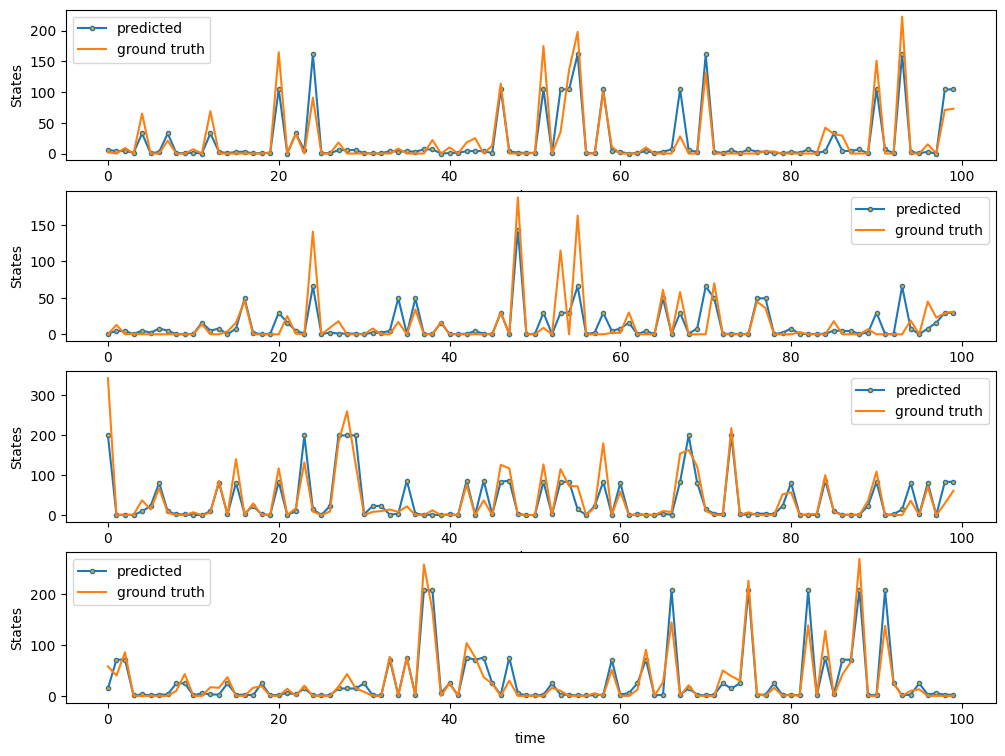

In [29]:
fig, ax = plt.subplots(nrows=X.shape[1], ncols=1, figsize=(12,9))
for i in range(len(ax)):
    ax[i].plot(predictions[i][:100], ".-", ms=6, mfc="orange", label="predicted")
    ax[i].plot(X_test.transpose()[i][:100], label="ground truth")
    ax[i].set_xlabel("time")
    ax[i].set_ylabel("States")
    ax[i].legend()

In [30]:
# save the model
with open("./models/hmm_model.pkl", "wb") as file: pickle.dump(best_model, file)